# Giocomo lab data
In this tutorial we will:
1. Load SpikeGLX ap files with [SpikeExtractors API](https://github.com/SpikeInterface/spikeextractors)
2. Perform spike sorting using [SpikeSorters API](https://github.com/SpikeInterface/spikesorters)
3. Store voltage traces and spike times in a NWB file

The following packages should be installed:
- [SpikeExtractors](https://github.com/SpikeInterface/spikeextractors)
- [SpikeSorters](https://github.com/SpikeInterface/spikesorters)
- [SpikeToolkit](https://github.com/SpikeInterface/spiketoolkit)
- [Herding Spikes 2](https://github.com/mhhennig/HS2)
- [pynwb](https://github.com/NeurodataWithoutBorders/pynwb)

To install: `pip install pynwb spikeextractors spikesorters spiketoolkit herdingspikes`

### 1 Load SpikeGLX ap files with SpikeExtractors API
Use *SpikeGLXRecordingExtractor* to read from *imec0.ap*, *imec0.lf* or *nidq* files and create a RecordingExtractor object:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import spikeextractors as se

fpath = 'G4_190620_keicontrasttrack_10secBaseline1_g0_t0.imec0.ap.bin'
#fpath = 'G4_190620_keicontrasttrack_10secBaseline1_g0_t0.imec0.lf.bin'
#fpath = 'G4_190620_keicontrasttrack_10secBaseline1_g0_t0.nidq.bin'
RX = se.SpikeGLXRecordingExtractor(npx_file=fpath, x_pitch=None, y_pitch=None)

print('Data shape: ', RX.get_traces().shape)
print('Sampling rate [Hz]: ', RX.get_sampling_frequency())
print('Properties: ', RX.get_shared_channel_property_names())

gain = RX.get_channel_gains([0])[0]  # converts traces from int16 to uV
xx = np.arange(0,3000.)/RX.get_sampling_frequency()
plt.plot(xx, gain*RX.get_traces()[0,0:3000])
plt.xlabel('Time [sec]')
plt.ylabel('LFP [uV]')
plt.show()

nChan: 385, nFileSamp: 346281
Data shape:  (384, 346281)
Sampling rate [Hz]:  30000.0
Properties:  ['gain', 'location']


### 2 Perform spike sorting using SpikeSorters API

In [2]:
import spikesorters as ss

print('Available sorters:\n', ss.available_sorters())

Available sorters:
 ['herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'klusta', 'mountainsort4', 'spykingcircus', 'tridesclous']


Choose a sorting algorithm and run it. 

In [3]:
sorter_name = 'herdingspikes'
SX = ss.run_sorter(sorter_name_or_class=sorter_name, recording=RX, output_folder='my_sorter_output')

# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 30000
# Localization On
# Number of recorded channels: 384
# Analysing frames: 346281; Seconds: 11.5427
# Frames before spike in cutout: 6
# Frames after spike in cutout: 30
# tcuts: 48 72
# tInc: 100000
# Analysing frames from -48 to 100072  (0.0%)
# Analysing frames from 99952 to 200072  (28.9%)
# Analysing frames from 199952 to 300072  (57.8%)
# Analysing frames from 299952 to 346281  (86.6%)
# Detection completed, time taken: 0:00:09.460508
# Time per frame: 0:00:00.027320
# Time per sample: 0:00:00.000071
Loaded 8568 spikes.
Fitting dimensionality reduction using all spikes...
...projecting...
...done
Clustering...
Clustering 8568 spikes...
number of seeds: 120
seeds/job: 31
using 4 cpus


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.0s finished


Number of estimated units: 42
Saving to C:\Users\Luiz\Google Drive (luiz@taufferconsulting.com)\client_ben\project_spike_extractors\data_giocomo_lab\G4_190620_keicontrasttrack_10secBaseline1_g0\my_sorter_output\HS2_sorted.hdf5


The sorting results will be stored in a *SortingExtractor* object and saved in a local folder as a `hdf5` file.

Let's check some results of the sorting process:

Number of estimated units:  42
Number of spikes unit #1: 669


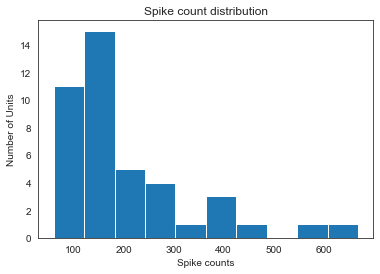

In [4]:
nUnits = len(SX.get_unit_ids())
spike_counts = [len(SX.get_unit_spike_train(i)) for i in range(nUnits)]

print('Number of estimated units: ', nUnits)
print('Number of spikes unit #1:', spike_counts[1])

plt.hist(spike_counts)
plt.title('Spike count distribution')
plt.xlabel('Spike counts')
plt.ylabel('Number of Units')
plt.show()

Let's now use the post-processing method of [SpikeToolkit](https://github.com/SpikeInterface/spiketoolkit) to recover the spike waveforms. The results will be stored as spike_features in the SX object. 

Unit #2 spike waveform, shape of array:  (669, 384, 90)
Let's look at the spike waveforms of Unit #1 in the most relevant channel:


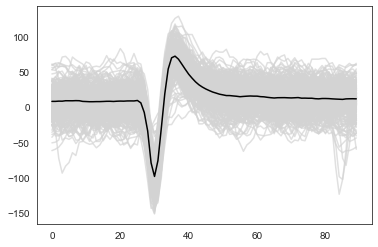

If that's the case, you should:
- check if distances (x_pitch, y_pitch) are correct when calling SpikeGLXRecordingExtractor()
- try another sorting algorithm


In [5]:
import spiketoolkit as st

wf = st.postprocessing.get_unit_waveforms(RX, SX, ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=False)

def most_relevant_ch(traces):
    """
    Calculates the most relevant channel for an Unit.
    Estimates the channel where the max-min difference of the average traces is greatest.

    traces : ndarray 
        ndarray of shape (nSpikes, nChannels, nSamples)
    """
    nSpikes = traces.shape[0]
    nChannels = traces.shape[1]
    nSamples = traces.shape[2]
    
    #average and std of spike traces per channel
    avg = np.mean(traces, axis=0)
    std = np.std(traces, axis=0)
    
    max_min = np.zeros(nChannels)
    for ch in range(nChannels):
        max_min[ch] = avg[ch,:].max() - avg[ch,:].min()
        
    relevant_ch = np.argmax(max_min)
    return relevant_ch
    
relevant_ch = most_relevant_ch(wf[0])
traces = wf[0][:, relevant_ch, :]

print('Unit #2 spike waveform, shape of array: ', SX.get_unit_spike_features(1,'waveforms').shape)
print("Let's look at the spike waveforms of Unit #1 in the most relevant channel:")
plt.figure()
plt.plot(traces.T, color='lightgray', alpha=.7)
plt.plot(np.mean(traces, axis=0), color='k')
plt.show()
print("WARNING: Non-spike waveforms are indication that the spike sorting results were not good.")
print("If that's the case, you should:")
print("- check if distances (x_pitch, y_pitch) are correct when calling SpikeGLXRecordingExtractor()")
print("- try another sorting algorithm")

### 3 Write the content to a NWB file 
We will use methods of the classes *NwbRecordingExtractor* and *NwbSortingExtractor* to store both voltge traces and sorted spike times into a `.nwb` file

In [6]:
import pynwb

fpath = 'giocomo_data.nwb'

# Optional keyword arguments to include in the nwb file
nwbfile_kwargs = {'experimenter':'Name',
                  'institution':'Institution',
                  'lab':'Giocomo lab'}

# Write recording data (voltage traces) to nwb file
se.NwbRecordingExtractor.write_recording(recording=RX,
                                         save_path=fpath,
                                         nwbfile_kwargs=nwbfile_kwargs)

C:\Users\Luiz\Anaconda3\envs\spike_extract\lib\site-packages\pynwb\file.py:621: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")



root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: {
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    Device <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    electrode_group_name <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'pynwb.core.DynamicTable'>
  experimenter: Name
  institution: Institution
  lab: Giocomo lab



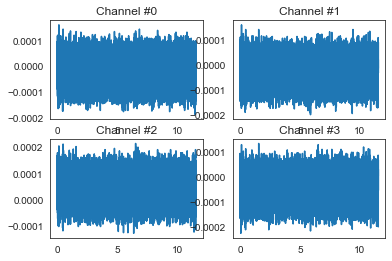

In [7]:
io = pynwb.NWBHDF5IO(fpath, 'r')
nwb = io.read()
print(nwb)
fs = nwb.acquisition['ElectricalSeries'].rate
nBins = nwb.acquisition['ElectricalSeries'].data.shape[0]
xx = np.arange(nBins)/fs
nElecs = nwb.acquisition['ElectricalSeries'].data.shape[1]
#plot extracelullar voltage traces
plt.figure()
for i in np.arange(4):
    plt.subplot(2,2,i+1)
    plt.plot(xx, nwb.acquisition['ElectricalSeries'].data[:,i])
    plt.title('Channel #'+str(i))
io.close()

In [8]:
# Write spiking data to nwb file
se.NwbSortingExtractor.write_sorting(sorting=SX,
                                     save_path=fpath)


units <class 'pynwb.misc.Units'>
Fields:
  colnames: ['spike_times' 'waveform_mean' 'waveform_sd']
  columns: (
    spike_times_index <class 'pynwb.core.VectorIndex'>,
    spike_times <class 'pynwb.core.VectorData'>,
    waveform_mean <class 'pynwb.core.VectorData'>,
    waveform_sd <class 'pynwb.core.VectorData'>
  )
  description: Autogenerated by NWBFile
  id: id <class 'pynwb.core.ElementIdentifiers'>

N° of units: 42
Number of spikes unit #1: 669


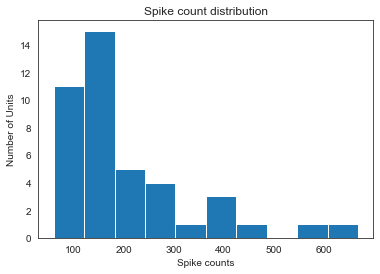

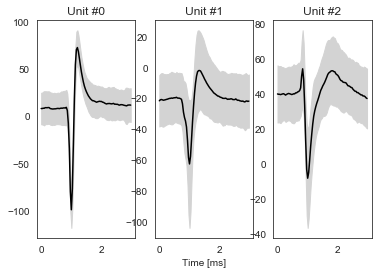

In [28]:
io = pynwb.NWBHDF5IO(fpath, 'r')
nwb = io.read()

nUnits = len(nwb.units['spike_times'][:])
spike_counts = [nwb.units['spike_times'][i].shape[0] for i in range(nUnits)]

print(nwb.units)
print('N° of units:', nUnits)
print('Number of spikes unit #1:', spike_counts[1])

plt.figure()
plt.hist(spike_counts)
plt.title('Spike count distribution')
plt.xlabel('Spike counts')
plt.ylabel('Number of Units')
plt.show()

fs = nwb.acquisition['ElectricalSeries'].rate
xx = 1000*np.arange(nwb.units['waveform_mean'][:].shape[1])/fs
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(xx, nwb.units['waveform_mean'][0,:], color='k')
axes[0].fill_between(xx, 
                     y1=nwb.units['waveform_mean'][0,:]+nwb.units['waveform_sd'][0,:], 
                     y2=nwb.units['waveform_mean'][0,:]-nwb.units['waveform_sd'][0,:],
                     color='lightgray')
axes[0].set_title('Unit #0')
axes[1].plot(xx, nwb.units['waveform_mean'][1,:], color='k')
axes[1].fill_between(xx, 
                     y1=nwb.units['waveform_mean'][1,:]+nwb.units['waveform_sd'][1,:], 
                     y2=nwb.units['waveform_mean'][1,:]-nwb.units['waveform_sd'][1,:],
                     color='lightgray')
axes[1].set_title('Unit #1')
axes[1].set_xlabel('Time [ms]')
axes[2].plot(xx, nwb.units['waveform_mean'][2,:], color='k')
axes[2].fill_between(xx, 
                     y1=nwb.units['waveform_mean'][2,:]+nwb.units['waveform_sd'][2,:], 
                     y2=nwb.units['waveform_mean'][2,:]-nwb.units['waveform_sd'][2,:],
                     color='lightgray')
axes[2].set_title('Unit #2')

io.close()